In [11]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.io import fits
import healpy as hp
%matplotlib inline

In [7]:
#base_dir = '/Users/Joseph/Brookhaven/Research/data/'  #directory in which catalogs are stored
base_dir = '/home/anze/Dropbox/work/dla_catalog_dr12q_lyb_lya/ascii_catalog'
DR12Qfits = '/home/anze/Data/BOSS.private/sas/dr12/boss/qso/DR12Q/DR12Q.fits'

#I had to change this part to work with python 3
def da():
    return map(lambda x:x.split(),open(base_dir+'/table3.dat').readlines())
def pet():
    return map(lambda x:x.split(),open(base_dir+'/DLA_DR12_v2.dat').readlines()[2:])

In [46]:
#Granet catalog
#nHi=np.array([float(x[-1]) for x in da()])
#z=np.array([float(x[-2]) for x in da()])   #dla redshift
#zq=np.array([float(x[7]) for x in da()])   #quasar redshift
p=np.array([float(x[-3]) for x in da()])   
#pn=np.array([float(x[-4]) for x in da()])
tid=np.array([int(x[0]) for x in da()])     #thing index
wh=np.where(p>0.9)
tid=tid[wh]

In [47]:
# Pasquier catalog
tidp=[int(x[0]) for x in pet()]             #thing index
zqp=np.array([float(x[4]) for x in pet()])  #quasar redshift
zp=np.array([float(x[9]) for x in pet()])   #dla redshift
nHip=np.array([float(x[10]) for x in pet()]) 

In [48]:
# quasar catalog
qso = fits.open(DR12Qfits)
qso_data = qso[1].data
thing_id = qso_data['THING_ID']  #thing_id for all of the quasars
thing_id = np.array(thing_id,dtype=float)
psf_mag = qso_data['PSFMAG']
psf_mag = np.array(psf_mag,dtype=float)
z_qso = qso_data['Z_PIPE']       #using 'Z_PIPE' as redshift of quasars
z_qso = np.asarray(z_qso,dtype=float) 

psf_u = psf_mag[:,0] #psf magnitudes in u band of all quasars

In [49]:
#finding the indices of the corresponding quasars in the catalogs with the DR12 catalog

p_psf_ind = []
for i in tidp:
    ind = np.where(thing_id - i == 0.) #(can be changed to different catalog by changing the thing_id)
    p_psf_ind.append(ind[0][0])  #indices of qso within parent catalog 

p_psf_ind = np.asarray(p_psf_ind,dtype=int)



g_psf_ind = []
for i in tid:  
    ind = np.where(thing_id - i == 0.)
    g_psf_ind.append(ind[0][0]) #indices of qso within parent catalog
g_psf_ind = np.asarray(g_psf_ind,dtype=int)


p_psf_u = psf_u[p_psf_ind]
g_psf_u = psf_u[g_psf_ind]

/home/anze/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide
/home/anze/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in divide


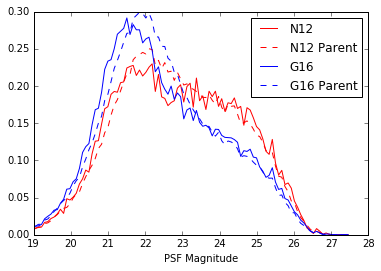

In [57]:
# Plot histogram of magnitude in the two catalogs

def m(x):                 
    return 0.5*(x[1:]+x[:-1])


#creating weighted histogram for all DR12 quasars (garnet (&pasquier?) parent)
hist_all,ed_all=np.histogram(psf_u,bins=100,range=(19,27.50),normed=True)
beg_sum = sum(hist_all)
dz=0.1
rdshift = np.arange(0, 7.4, dz)
qso_hist = np.histogram(z_qso, bins=rdshift)
dla_hist = np.histogram(z_qso[p_psf_ind], bins=rdshift)
dla_histg = np.histogram(z_qso[g_psf_ind], bins=rdshift)
weights = dla_hist[0]*1.0/qso_hist[0]
weightsg = dla_histg[0]*1.0/qso_hist[0]
z_bins = (z_qso/dz).astype('int')
qweights = weights[z_bins]
qweightsg = weightsg[z_bins]
#creating weighted histogram for pasquier quasars
histp,edp=np.histogram(psf_u[p_psf_ind],bins=100,range=(19,27.50),normed=True)
#histp,edp=np.histogram(z_qso[p_psf_ind],bins=100,normed=True)
plt.plot(m(edp),histp,label='N12',color='red')
phistp,pedp=np.histogram(psf_u,weights=qweights, bins=100,range=(19,27.50),normed=True)
#phistp,pedp=np.histogram(z_qso,weights=qweights, bins=100,normed=True)
plt.plot(m(pedp),phistp,label='N12 Parent',color='red',ls='--')


histp,edp=np.histogram(psf_u[g_psf_ind],bins=100,range=(19,27.50),normed=True)
#histp,edp=np.histogram(z_qso[p_psf_ind],bins=100,normed=True)
plt.plot(m(edp),histp,label='G16',color='blue')
phistp,pedp=np.histogram(psf_u,weights=qweightsg, bins=100,range=(19,27.50),normed=True)
#phistp,pedp=np.histogram(z_qso,weights=qweights, bins=100,normed=True)
plt.plot(m(pedp),phistp,label='G16 Parent',color='blue', ls='--')


#plt.plot(rdshift,weights)


plt.xlabel('PSF Magnitude')
plt.legend()
plt.savefig("umagdist.pdf")
plt.show()

In [44]:
len(qweightsg)

297301

In [ ]:


beg_sum = sum(histp)
dz=0.1
rdshift = np.arange(0, 7.2, dz)
qso_hist = np.histogram(zqp, bins=rdshift)
dla_hist = np.histogram(zp, bins=rdshift)
weights = dla_hist[0]/qso_hist[0]
z_bins = (zqp/dz).astype('int')
for i in range(len(edp)-1):
    ind = np.where((p_psf_u>edp[i]) * (p_psf_u<edp[i+1]))
    w_qso = weights[z_bins[ind]]
    histp[i] = histp[i]*sum(w_qso)/len(w_qso)
histp = np.asarray(histp,dtype=float)
sump = sum(histp[np.logical_not(np.isnan(histp))])
histp *= beg_sum/sump
plt.plot(m(edp),histp,label='Petitjean Parent',color='orange',ls='--')

#creating weighted histogram for garnet quasars
w=np.where(p>0.80)                 #take just p>0.8 from Granet as true DLAs, gives a right number
g_psf_uw = g_psf_u[w];
zw = z[w]; 
zqw = zq[w]
hist,ed=np.histogram(g_psf_uw,bins=100,range=(19,27.50),normed=True)
plt.plot(m(ed),hist,label='Garnet',color='blue')
beg_sum = sum(hist)
dz=0.1
rdshift = np.arange(0, 7.2, dz)
qso_hist = np.histogram(zqw, bins=rdshift)
dla_hist = np.histogram(zw, bins=rdshift)
weights = dla_hist[0]/qso_hist[0]
z_bins = (zqw/dz).astype('int')
for i in range(len(ed_all)-1):
    ind = np.where((g_psf_uw>ed[i]) * (g_psf_uw<ed[i+1]))
    w_qso = weights[z_bins[ind]]
    hist[i] = hist[i]*sum(w_qso)/len(w_qso)
hist = np.asarray(hist,dtype=float)
sumg = sum(hist[np.logical_not(np.isnan(hist))])
hist *= beg_sum/sumg
plt.plot(m(ed),hist,label='Garnet Parent',color='blue',ls='--')